### Import

In [46]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

### Get the data

In [47]:
columns = ['date', 'time', 'event_type', 'location', 'user_id', 'source', 'topic']
read = pd.read_csv('/home/katz/dilans-blog/data/all_read.csv', delimiter = ';', names = columns)
read['date'] = pd.to_datetime(read['date'], format='%Y-%m-%d')
read = read.drop(columns=['time'])
read

,date,event_type,location,user_id,source,topic
0,2018-01-01,read,country_7,2458151261,SEO,North America
1,2018-01-01,read,country_7,2458151262,SEO,South America
2,2018-01-01,read,country_7,2458151263,AdWords,Africa
3,2018-01-01,read,country_7,2458151264,AdWords,Europe
4,2018-01-01,read,country_8,2458151265,Reddit,North America
...,...,...,...,...,...,...
581872,2018-03-31,read,country_4,2458361163,NaN,Africa
581873,2018-03-31,read,country_6,2458361177,NaN,Asia
581874,2018-03-31,read,country_7,2458361244,NaN,North America
581875,2018-03-31,read,country_7,2458361267,NaN,Europe


### Get the first readers data

In [48]:
first_readers = read[read.source.notna()][['user_id', 'location', 'source', 'topic']]
first_readers

,user_id,location,source,topic
0,2458151261,country_7,SEO,North America
1,2458151262,country_7,SEO,South America
2,2458151263,country_7,AdWords,Africa
3,2458151264,country_7,AdWords,Europe
4,2458151265,country_8,Reddit,North America
...,...,...,...,...
581731,2458361279,country_1,SEO,North America
581735,2458361280,country_6,AdWords,Asia
581738,2458361281,country_8,AdWords,Europe
581742,2458361282,country_5,AdWords,Europe


### Get the returning readers id

In [49]:
returning_readers = read[read.source.isna()].groupby('user_id').count().reset_index()[['user_id']]
returning_readers['returning'] = 1
returning_readers

,user_id,returning
0,2458151267,1
1,2458151271,1
2,2458151273,1
3,2458151276,1
4,2458151278,1
...,...,...
66226,2458361271,1
66227,2458361276,1
66228,2458361278,1
66229,2458361282,1


### Get the customers id

In [50]:
columns = ['date', 'event_type', 'user_id', 'price']
buy = pd.read_csv('/home/katz/dilans-blog/data/all_buy.csv', delimiter = ';', names = columns)
buy = buy.groupby('user_id').count().reset_index()[['user_id']]
buy['customer'] = 1

In [51]:
buy

,user_id,customer
0,2458151279,1
1,2458151323,1
2,2458151349,1
3,2458151364,1
4,2458151367,1
...,...,...
6643,2458346117,1
6644,2458346133,1
6645,2458346159,1
6646,2458346179,1


### Merge the tables

In [52]:
known = pd.merge(first_readers, returning_readers, on = 'user_id', how = 'left')

In [53]:
known = pd.merge(known, buy, on = 'user_id', how = 'left')

In [54]:
known = known[['user_id', 'location', 'source', 'topic', 'returning', 'customer']]

In [55]:
known.loc[known.returning.isna(), 'returning'] = 0

In [56]:
known.loc[known.customer.isna(), 'customer'] = 0

In [57]:
known['returning'] = known['returning'].astype(int)
known['customer'] = known['customer'].astype(int)

In [58]:
known.groupby('customer').count()

,user_id,location,source,topic,returning
customer,,,,,
0,203375,203375,203375,203375,203375
1,6648,6648,6648,6648,6648


### Decoding our data set

#### Location

In [59]:
location_data = known.groupby('location').count()
location_decoder = {}

In [60]:
location_decoder = {index: i for i, index in enumerate(location_data.index)}

In [61]:
location_decoder

{'country_1': 0,
 'country_2': 1,
 'country_3': 2,
 'country_4': 3,
 'country_5': 4,
 'country_6': 5,
 'country_7': 6,
 'country_8': 7}

In [62]:
known.loc[:, 'location'] = known['location'].map(location_decoder)

#### Source

In [63]:
source_data = known.groupby('source').count()
source_decoder = {}

In [64]:
source_decoder = {index: i for i, index in enumerate(source_data.index)}

In [65]:
source_decoder

{'AdWords': 0, 'Reddit': 1, 'SEO': 2}

In [66]:
known.loc[:, 'source'] = known['source'].map(source_decoder)

#### Topic

In [67]:
topic_data = known.groupby('topic').count()
topic_decoder = {}

In [68]:
topic_decoder = {index: i for i, index in enumerate(topic_data.index)}

In [69]:
topic_decoder

{'Africa': 0,
 'Asia': 1,
 'Australia': 2,
 'Europe': 3,
 'North America': 4,
 'South America': 5}

In [70]:
known.loc[:, 'topic'] = known['topic'].map(topic_decoder)

### Machine Learning (Random Forest Classifier)

In [71]:
known

,user_id,location,source,topic,returning,customer
0,2458151261,6,2,4,0,0
1,2458151262,6,2,5,0,0
2,2458151263,6,0,0,0,0
3,2458151264,6,0,3,0,0
4,2458151265,7,1,4,0,0
...,...,...,...,...,...,...
210018,2458361279,0,2,4,0,0
210019,2458361280,5,0,1,0,0
210020,2458361281,7,0,3,0,0
210021,2458361282,4,0,3,1,0


In [72]:
# Input variables
x = known[['source', 'location', 'topic']]

In [73]:
# n_estimators how many decisions tree will predict
# The bigger the dataset, the more tree we need
# On huge datasets min 100 tree

### Separate model for each target variable

#### Model for predict returning

In [74]:
# Output variable
y_returning = known['returning']
model_returning = RandomForestClassifier(n_estimators = 200)
model_returning = model_returning.fit(x.values, y_returning)

In [75]:
model_returning

RandomForestClassifier(n_estimators=200)

#### Model for predict customer

In [76]:
# Output variable
y_customer = known['customer']

##### Adjust class weights for the model

In [77]:
# Common problem is that the model may become biased towards the majority class, leading to poor performance on the minority class
# Adjust class weights for imbalanced dataset
class_weights = {0: 1, 1: 10}  # Adjust the weights based on the imbalance

In [78]:
model_customer = RandomForestClassifier(n_estimators=100, class_weight=class_weights)
model_customer = model_customer.fit(x.values, y_customer)

##### Sample user

In [79]:
sample_user = [0, 3, 1]

In [80]:
model_returning.predict([sample_user])

array([1])

In [81]:
model_customer.predict([sample_user])

array([1])

In [82]:
source_decoder

{'AdWords': 0, 'Reddit': 1, 'SEO': 2}

In [83]:
source_decoder_reverse = {v: k for k, v in source_decoder.items()}
location_decoder_reverse = {v: k for k, v in location_decoder.items()}
topic_decoder_reverse = {v: k for k, v in topic_decoder.items()}

#### Generate predictions for all user groups

In [84]:
predictions = []

for i in range(len(source_decoder)):
    for f in range(len(location_decoder)):
        for g in range(len(topic_decoder)):
            sample_user = [i, f, g]
            predicted_returning = model_returning.predict([sample_user])[0]
            predicted_customer = model_customer.predict([sample_user])[0]
            predictions.append([source_decoder_reverse[i], location_decoder_reverse[f], topic_decoder_reverse[g], predicted_returning, predicted_customer])

In [85]:
pred = pd.DataFrame(predictions, columns=['Source', 'Location', 'Topic', 'Predicted Returning', 'Predicted Customer'])

In [86]:
pivot_returning = pred.pivot_table(index=['Source', 'Location'], columns='Topic', values='Predicted Returning', aggfunc='first')

### Visualisation on heatmap

##### Returning User Prediction

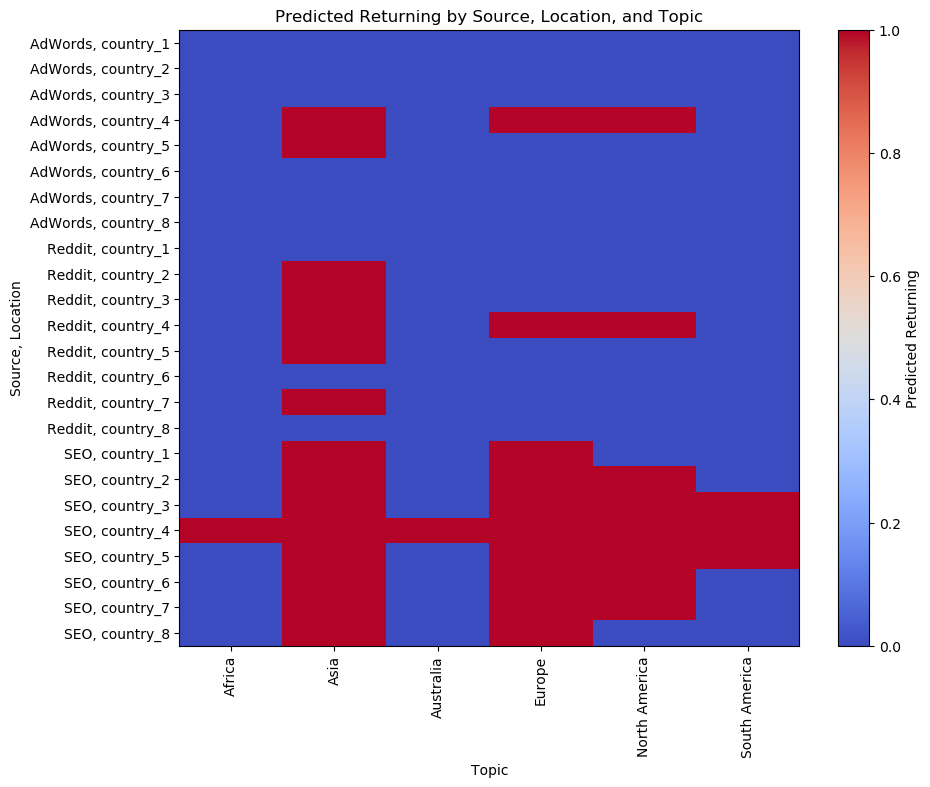

In [87]:
plt.figure(figsize=(10, 8))
plt.title('Predicted Returning by Source, Location, and Topic')
plt.xlabel('Topic')
plt.ylabel('Source, Location')
plt.imshow(pivot_returning, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Predicted Returning')
plt.xticks(ticks=range(len(topic_decoder)), labels=list(topic_decoder.keys()), rotation=90)
plt.yticks(ticks=range(len(source_decoder) * len(location_decoder)),
           labels=[f'{source_decoder_reverse[i // len(location_decoder)]}, {location_decoder_reverse[i % len(location_decoder)]}'
                   for i in range(len(source_decoder) * len(location_decoder))])
plt.show()

##### Customer Prediction

In [88]:
pivot_customer = pred.pivot_table(index=['Source', 'Location'], columns='Topic', values='Predicted Customer', aggfunc='first')

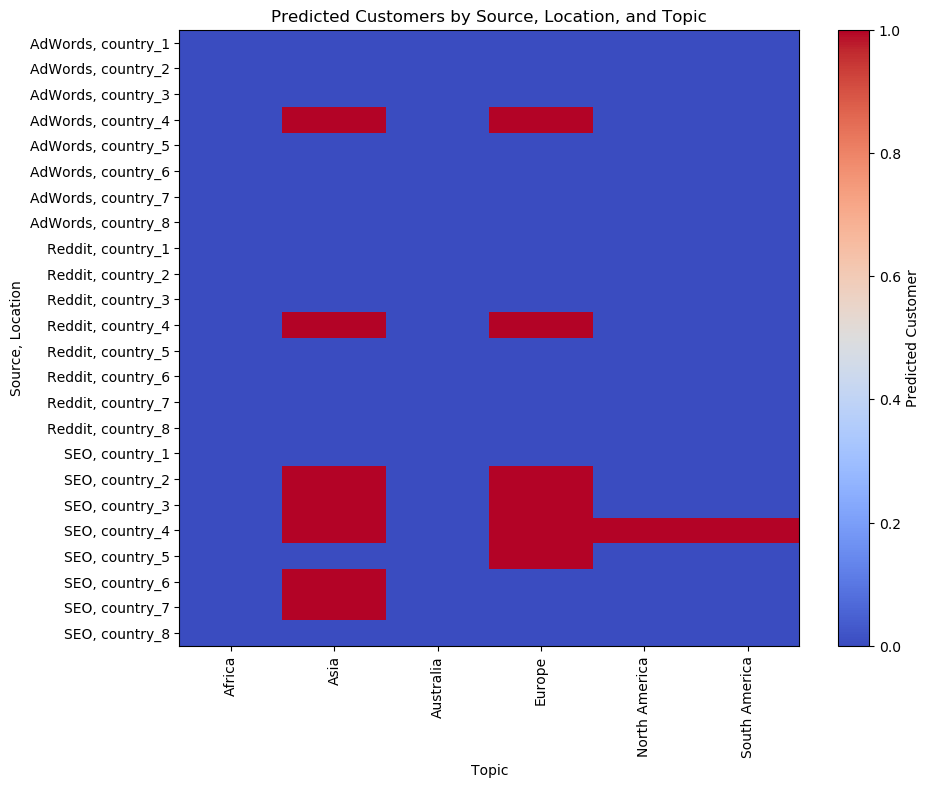

In [89]:
plt.figure(figsize=(10, 8))
plt.title('Predicted Customers by Source, Location, and Topic')
plt.xlabel('Topic')
plt.ylabel('Source, Location')
plt.imshow(pivot_customer, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Predicted Customer')
plt.xticks(ticks=range(len(topic_decoder)), labels=list(topic_decoder.keys()), rotation=90)
plt.yticks(ticks=range(len(source_decoder) * len(location_decoder)),
           labels=[f'{source_decoder_reverse[i // len(location_decoder)]}, {location_decoder_reverse[i % len(location_decoder)]}'
                   for i in range(len(source_decoder) * len(location_decoder))])
plt.show()